In [1]:
# # Standard libraries
# import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA

# Append base directory to path
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")
sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# # User libraries
from matlab.matlab_lib import loadmat
from matlab.matlab_yaro_lib import matstruct2dict, read_neuro_perf
from matlab.aux_functions import merge_dicts
from qt_wrapper import gui_fname, gui_fpath
from classify_lib import linear_classifiability, linear_classifiability_eqpart

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/TNU2019-Project/src/lib


In [8]:
# Get Path to matlab file
matlab_filepath = gui_fname("MAR fit file", '../../data/intermediate/', filter='Matlab files (*.mat)')

# Load file
matlab_dict = loadmat(matlab_filepath)

# Convert matlab structures to dictionaries
dataAR = [matstruct2dict(s) for s in matlab_dict['amat_trials']]

# Merge dictionaries and stack all results
dataAR = np.array(merge_dicts(dataAR)['a'])

print('Resulting data shape', dataAR.shape)

Resulting data shape (590, 12, 12)


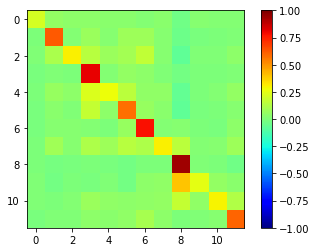

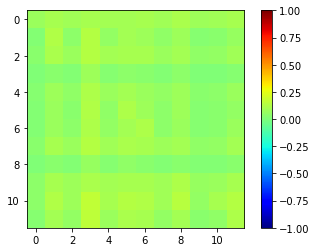

In [3]:
plt.figure()
plt.imshow(-np.mean(dataAR, axis=0), cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.std(dataAR, axis=0), cmap='jet', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Linear Classification (LC)

### 1. LC based on neuronal PCA

1. Compute PCA for each channel
2. Choose N PCA components for each channel, project, make compressed data set
3. Compute LC

In [6]:
#data_path = gui_fpath("Select data path", './')
data_path = '../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour'

# Read LVM file from command line
dataNeuro, behaviour = read_neuro_perf(data_path)

nTrials, nTimes, nChannels = dataNeuro.shape

Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour


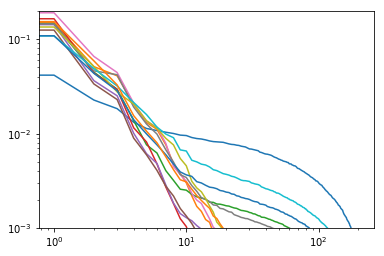

Number of PCA selected by channel


,0,1,2,3,4,5,6,7,8,9,10,11
N_PCA,9,7,5,5,5,4,7,6,7,7,5,6


Final shape of the data (590, 73)


In [7]:
# Perform PCA
plt.figure()

data_pca = []
for i in range(nChannels):
    pca = PCA()
    data_pca_this = pca.fit_transform(dataNeuro[:,:,i])
    plt.loglog(pca.explained_variance_ratio_)
    selected_pca = pca.explained_variance_ratio_ > 1.0e-2
    data_pca += [data_pca_this[:, selected_pca]]
plt.ylim(1.0e-3, 2.0e-1)
plt.show()

print("Number of PCA selected by channel")
display(pd.DataFrame({'N_PCA' : [data_pca[i].shape[1] for i in range(nChannels)]}).T)

data_pca_stacked = np.hstack(data_pca)
print("Final shape of the data", data_pca_stacked.shape)

In [9]:
def numidx2arr(idx, N):
    arr = np.zeros(N)
    arr[idx] = 1
    return arr

labelsLarge = {k : numidx2arr(behaviour[k]-1, nTrials) for k in ['iGO', 'iNOGO']}
labelsSmall = {k : numidx2arr(behaviour[k]-1, nTrials) for k in ['iMISS', 'iFA']}

print([(k, np.sum(v)) for k,v in labelsLarge.items()])
print([(k, np.sum(v)) for k,v in labelsSmall.items()])

lclassesLarge = {k : linear_classifiability(data_pca_stacked, v, Nperm=1000, print_freq=100) for k,v in labelsLarge.items()}
lclassesSmall = {k : linear_classifiability_eqpart(data_pca_stacked, v, Nperm=10000, print_freq=1000) for k,v in labelsSmall.items()}

[('iGO', 280.0), ('iNOGO', 238.0)]
[('iMISS', 16.0), ('iFA', 56.0)]
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


Z-score for iGO is 21.50799105790996


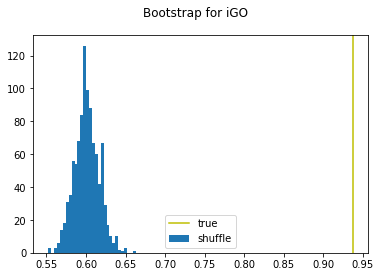

Z-score for iNOGO is 22.25077484464547


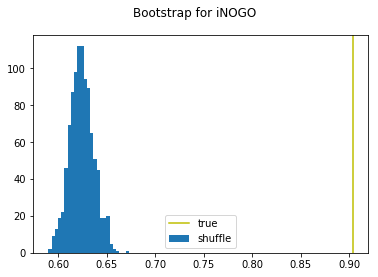

2-sample Z-score for iMISS is 0.6215148647257752


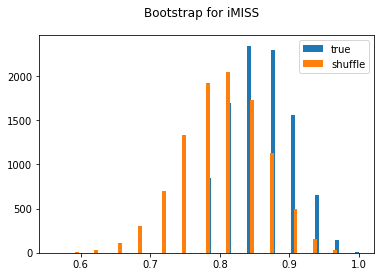

2-sample Z-score for iFA is 3.8051794566998085


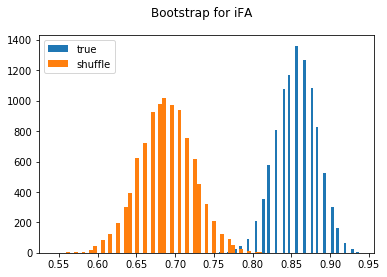

In [10]:
zscore = lambda x, mu: (mu-np.nanmean(x)) / np.nanstd(x)
zscore_2sample = lambda x, y: (np.nanmean(x) - np.nanmean(y))/np.sqrt(np.nanvar(x) + np.nanvar(y))

for i, (k, lclass) in enumerate(lclassesLarge.items()):
    print("Z-score for "+k+" is", zscore(lclass['acc_shuffle'], lclass['acc_true'])) 

    plt.figure()
    plt.suptitle('Bootstrap for '+k)
    plt.axvline(x=lclass['acc_true'], ymin=0, ymax=1, label='true', color='y')
    plt.hist(lclass['acc_shuffle'],bins='auto', label='shuffle')
    plt.legend()
    plt.show()
    
for i, (k, lclass) in enumerate(lclassesSmall.items()):
    print("2-sample Z-score for "+k+" is", zscore_2sample(lclass['acc_true'], lclass['acc_shuffle']))

    plt.figure()
    plt.suptitle('Bootstrap for '+k)
    plt.hist(lclass['acc_true'],bins='auto', label='true')
    plt.hist(lclass['acc_shuffle'],bins='auto', label='shuffle')
    plt.legend()
    plt.show()

### 2. LC based on behavioural PCA

### 3. LC based on neuronal AR matrix

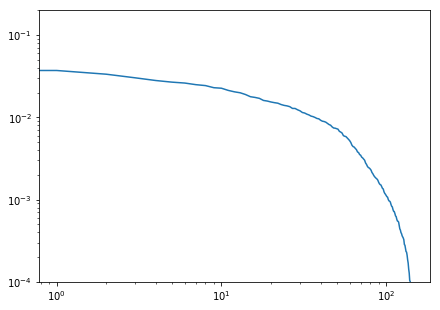

Final shape of the data (590, 75)


In [11]:
dataAR_flat = dataAR.reshape(nTrials, nChannels**2)

# Perform PCA
plt.figure(figsize=(7,5))

pca = PCA()
data_pca = pca.fit_transform(dataAR_flat)
plt.loglog(pca.explained_variance_ratio_)
selected_pca = pca.explained_variance_ratio_ > 3.0e-3
data_pca = data_pca[:, selected_pca]
plt.ylim(1.0e-4, 2.0e-1)
plt.show()

print("Final shape of the data", data_pca.shape)

In [12]:
labelsLarge = {k : numidx2arr(behaviour[k]-1, nTrials) for k in ['iGO', 'iNOGO']}
labelsSmall = {k : numidx2arr(behaviour[k]-1, nTrials) for k in ['iMISS', 'iFA']}

print([(k, np.sum(v)) for k,v in labelsLarge.items()])
print([(k, np.sum(v)) for k,v in labelsSmall.items()])

lclassesLarge = {k : linear_classifiability(data_pca, v, Nperm=1000, print_freq=100) for k,v in labelsLarge.items()}
lclassesSmall = {k : linear_classifiability_eqpart(data_pca, v, Nperm=10000, print_freq=1000) for k,v in labelsSmall.items()}

[('iGO', 280.0), ('iNOGO', 238.0)]
[('iMISS', 16.0), ('iFA', 56.0)]
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


Z-score for iGO is 14.548196877250806


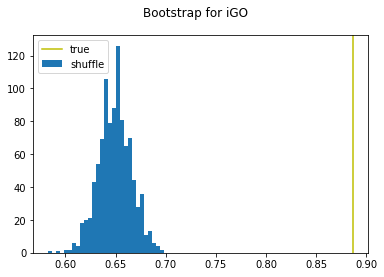

Z-score for iNOGO is 9.570139986854164


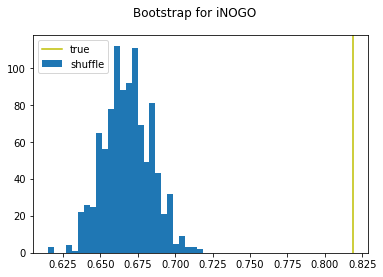

2-sample Z-score for iMISS is -0.056275895930838295


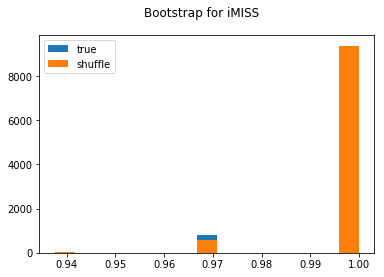

2-sample Z-score for iFA is 1.1794198353045997


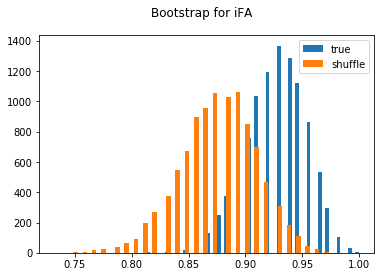

In [13]:
zscore = lambda x, mu: (mu-np.nanmean(x)) / np.nanstd(x)
zscore_2sample = lambda x, y: (np.nanmean(x) - np.nanmean(y))/np.sqrt(np.nanvar(x) + np.nanvar(y))

for i, (k, lclass) in enumerate(lclassesLarge.items()):
    print("Z-score for "+k+" is", zscore(lclass['acc_shuffle'], lclass['acc_true'])) 

    plt.figure()
    plt.suptitle('Bootstrap for '+k)
    plt.axvline(x=lclass['acc_true'], ymin=0, ymax=1, label='true', color='y')
    plt.hist(lclass['acc_shuffle'],bins='auto', label='shuffle')
    plt.legend()
    plt.show()
    
for i, (k, lclass) in enumerate(lclassesSmall.items()):
    print("2-sample Z-score for "+k+" is", zscore_2sample(lclass['acc_true'], lclass['acc_shuffle']))

    plt.figure()
    plt.suptitle('Bootstrap for '+k)
    plt.hist(lclass['acc_true'],bins='auto', label='true')
    plt.hist(lclass['acc_shuffle'],bins='auto', label='shuffle')
    plt.legend()
    plt.show()